In [1]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import nltk
import ast

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# plotly items in here, but have API key in another file

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go

# Read & Categorize Reviews

Decided to cut down on the data by looking at just english and math departments. These have sufficient reviews to be able to still keep a fair number. Currently working with reviews from three states. Have created 8 categories for reviews that correspond grouping binary variables B/G, E/M, F/N(Math).

In [3]:
engMath_df = pd.read_csv('../smp_data/engMath_ME_NH_RI.csv',encoding='utf-8')

In [4]:
# Create the three letter code
# code for these dataframes and fields
# letter 1 = Bad / Good (corresponding to 0 or 1 on 'sentiment')
# letter 2 = English / Math (with an N for 'number')
# letter 3 = Female / Male

# These should partition the data -- that is, they should sum up to all the reviews
# And no review should be in more than one code
engMath_df['code'] = np.where(engMath_df['sentiment'], 'G', 'B')
engMath_df['code'] = engMath_df['code'] + np.where(engMath_df['department']=='English', 'E','N')
engMath_df['code'] = engMath_df['code'] + np.where(engMath_df['genderBest']=='female','F','M')

# Review Counts and Overall Scores (by Department/Gender)

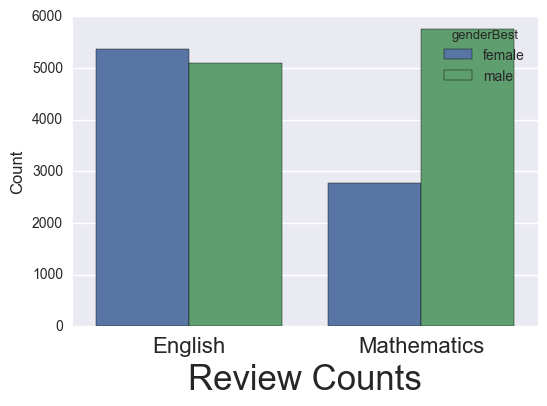

In [6]:
plt.figure()
plt.rcParams["figure.figsize"] = [12,5]
sns.countplot(x="department", data=engMath_df, hue='genderBest');
plt.xticks(fontsize=16)
plt.xlabel("Review Counts",fontsize=25)
plt.ylabel("Count",fontsize=12)
plt.show()

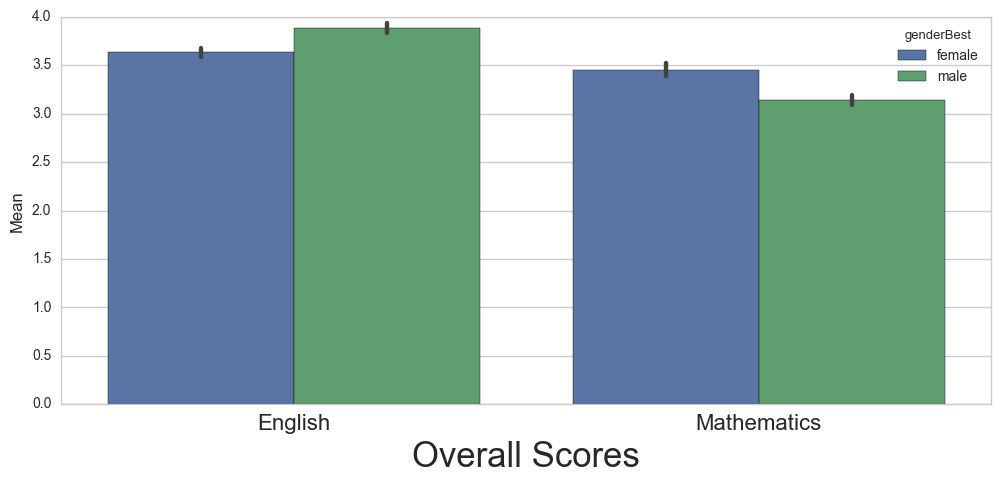

In [308]:
plt.figure()
plt.rcParams["figure.figsize"] = [12,5]
sns.barplot(x='department',y="overall", hue='genderBest',data=engMath_df);
plt.xticks(fontsize=16)
plt.xlabel("Overall Scores",fontsize=25)
plt.ylabel("Mean",fontsize=12)
plt.show()

# Sample Reviews so categories are even

In [10]:
# count the number of reviews in each code
tots = engMath_df[['code','profID']].groupby('code').count().reset_index()

In [11]:
tots

,code,profID
0,BEF,2031
1,BEM,1575
2,BNF,1183
3,BNM,2899
4,GEF,3339
5,GEM,3531
6,GNF,1589
7,GNM,2851


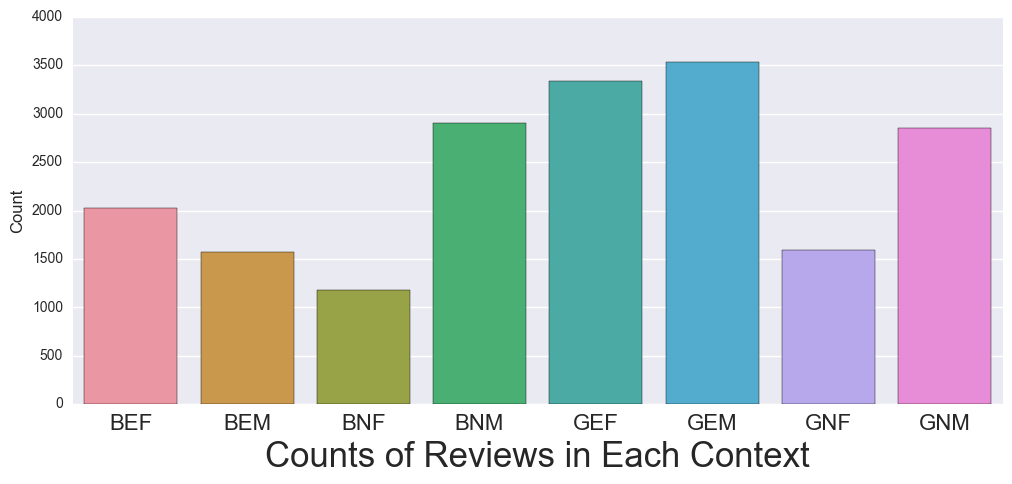

In [13]:
# barplot of counts for all different
plt.rcParams["figure.figsize"] = [12,5]
plt.figure()
sns.barplot(x='code',y='profID',data = tots)
xticks = ['BEF','BEM','BNF','BNM','GEF','GEM','GNF','GNM']
plt.xticks(range(len(xticks)),xticks,fontsize=16)
plt.xlabel("Counts of Reviews in Each Context",fontsize=25)
plt.ylabel("Count",fontsize=12)
plt.show()


In [14]:
#sampling so there are 1100 reviews in each category
sampled_df = engMath_df[engMath_df['code']=='BEF'].sample(n=1100)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='BEM'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='BNF'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='BNM'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='GEF'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='GEM'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='GNF'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='GNM'].sample(n=1100), ignore_index=True)

In [15]:
# in reading from csv the "stems" column has become like a string (even though dtype is object)
sampled_df['stems'] = sampled_df['stems'].apply(ast.literal_eval)

# Text Analysis

In [11]:
# Define category-word pairs
def pairsDeptGend(rev_df):
    pairList=[]
    for row in rev_df:
        pairList.extend([(rev_df['code'],stem) for stem in rev_df['stems']])  
    return list(set(pairList))

In [12]:
import itertools

In [3]:
# now for each stem in a review, pair up the stem and the code for that review
pairList = sampled_df.apply(pairsDeptGend,axis=1)

NameError: name 'sampled_df' is not defined

In [92]:
pairList = list(itertools.chain(*list(pairList)))

In [50]:
# Conditional frequency distribution
cfd = nltk.ConditionalFreqDist(pairList)

In [17]:
#example of looking a table of interesting words
codes = ['BEF', 'BEM', 'BNF', 'BNM', 'GEF', 'GEM', 'GNF', 'GNM']
words = ['nice','care','help','understand','good','best','great','funni','fun','humor']
#words = ['engag','grade','funni','fun','humor','book','paper','write','bore','rude','play']

In [51]:
cfd.tabulate(conditions=codes, samples=words)

          nice       care       help understand       good       best      great      funni        fun      humor 
BEF         50         18        104         70         85         13         19          9         13          3 
BEM         48         41        102         46         91         13         30         13         16          6 
BNF         77         38        179        159        110         23         30          3          4          4 
BNM         88         51        157        154         95         18         19         16         14          0 
GEF         93         80        320         70        113        179        261         52        100         21 
GEM         69         61        233         56        128        179        293         99        107         30 
GNF        113         74        449        206        137        241        242         31         37          5 
GNM         95         63        345        186        148        227        286

Note that math is definately a male field, and english is somewhat more female (although not nearly as drastically. Look at how EM and NF are opposit.)

In [167]:
# can pull most common words
cfd['BEF'].most_common(20)

[('class', 563),
 ('teacher', 245),
 ('take', 231),
 ('grade', 202),
 ('student', 172),
 ('paper', 155),
 ('like', 151),
 ('assign', 136),
 ('professor', 134),
 ('dont', 134),
 ('doesnt', 134),
 ('ever', 131),
 ('time', 129),
 ('teach', 129),
 ('get', 127),
 ('help', 125),
 ('write', 124),
 ('comment', 124),
 ('worst', 120),
 ('hard', 119)]

# Make CFD into a dataframe

In [ ]:
from collections import defaultdict

In [1]:
# Return the conditional frequency distribution as a dataframe
def cfdDF(data):
    cfd = {}
    for cond, freq in data:
        try:
            cfd.loc[cond,freq] += 1
        except KeyError:
            try:
                cfd.loc[cond,freq] = 1
            except KeyError:
                cfd[cond] = {freq: 1}
    cfd_df = pd.DataFrame(cfd).fillna(0)  
    return cfd_df.astype(int)


In [2]:
# create cfd dataframe
cfd_df = cfdDF(pairList)

NameError: name 'pairList' is not defined

In [94]:
#totaling up the words for the different cotexts
cfd_df['total'] = cfd_df[['BEF','GEF','BNF','GNF','BEM','GEM','BNM','GNM']].sum(axis=1)

In [95]:
# pulling the binary categories back out again
cfd_df['female']=cfd_df[['BEF','BNF','GEF','GNF']].sum(axis=1)
cfd_df['male']=cfd_df[['BEM','BNM','GEM','GNM']].sum(axis=1)
cfd_df['english']=cfd_df[['BEF','BEM','GEF','GEM']].sum(axis=1)
cfd_df['math']=cfd_df[['BNF','BNM','GNF','GNM']].sum(axis=1)
cfd_df['good']=cfd_df[['GEF','GEM','GNF','GNM']].sum(axis=1)
cfd_df['bad']=cfd_df[['BEF','BEM','BNF','BNM']].sum(axis=1)

In [96]:
cfd_df['gender']=cfd_df['female']-cfd_df['male']
cfd_df['dept']=cfd_df['english']-cfd_df['math']
cfd_df['quality']=cfd_df['bad']-cfd_df['good']


In [97]:
cfd_df = cfd_df.reset_index()

# Graph context totals

In [98]:
# total up all of the previously defined columns
# turn that into a df to graph
totals = cfd_df[['index','BEF', 'BEM', 'BNF', 'BNM', 'GEF', 'GEM', 'GNF', 'GNM','female','male','english','math','good','bad']].sum()
tot_df = pd.DataFrame(totals).drop('index').rename(columns={0:'count'}).reset_index()

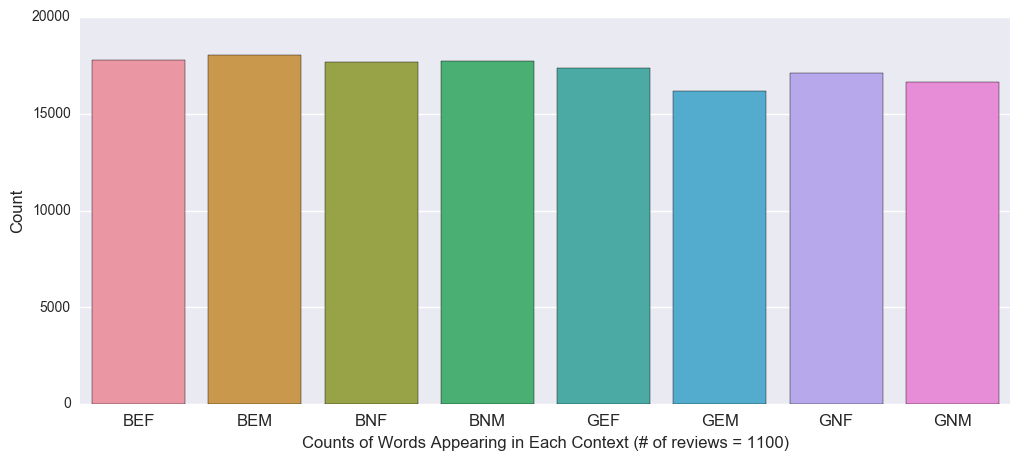

In [99]:
# barplot of counts for codes
# these are more variable than I would like
# getting more reviews scraped should help
plt.rcParams["figure.figsize"] = [12,5]
plt.figure()
sns.barplot(x='index',y='count',data = tot_df[0:8])
xticks = ['BEF', 'BEM', 'BNF', 'BNM', 'GEF', 'GEM', 'GNF', 'GNM']
plt.xticks(range(len(xticks)),xticks,fontsize=12)
plt.xlabel("Counts of Words Appearing in Each Context (# of reviews = 1100)",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.show()

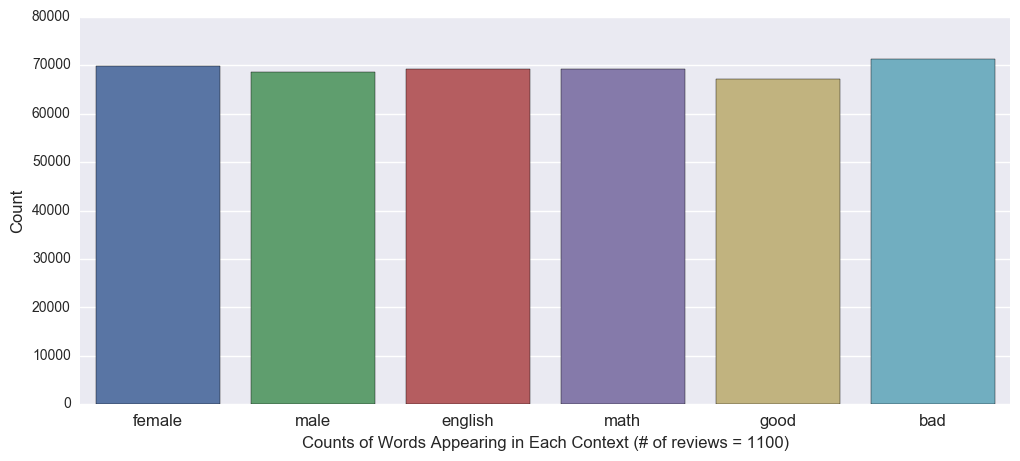

In [100]:
# barplot of counts aspects of review
# note these are basically equal
plt.rcParams["figure.figsize"] = [12,5]
plt.figure()
sns.barplot(x='index',y='count',data = tot_df[8:14])
xticks = ['female','male','english','math','good','bad']
plt.xticks(range(len(xticks)),xticks,fontsize=12)
plt.xlabel("Counts of Words Appearing in Each Context (# of reviews = 1100)",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.show()

In [301]:
# plotly plot -- have to put in API to run this
# current version at https://plot.ly/~faroop/8
# allows for hover to see word
# scatter of gender and department with quality giving the colors
trace = go.Scatter(
    x=cfd_df['gender'],
    y=cfd_df['dept'],
    text=cfd_df['index'],
    mode = 'markers',
    marker = dict(
        size = 10,
        color = cfd_df['quality'],
        colorscale='Viridis',
        showscale = True,
        line = dict(
            width = 1,
        )
    )
)

data = [trace]

layout = dict(title = 'Gender vs Department, colored by Quality',
              hovermode = 'closest',
              yaxis = dict(title='Department'),
              xaxis = dict(title = 'Gender')
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='reviewText2')

In [ ]:
# scatter of gender and department with quality giving the colors
trace = go.Scatter(
    x=cfd_df['gender'],
    y=cfd_df['dept'],
    text=cfd_df['index'],
    mode = 'markers',
    marker = dict(
        size = 10,
        color = cfd_df['quality'],
        colorscale='Viridis',
        showscale = True,
        line = dict(
            width = 1,
        )
    )
)

data = [trace]

layout = dict(title = 'Gender vs Department, colored by Quality',
              hovermode = 'closest',
              yaxis = dict(title='Department'),
              xaxis = dict(title = 'Gender')
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='reviewText_zoom')

# Interesting Words

To find interesting words, then need to take everything far enough away from the origin. Note that words that are very large and right on an axis are likely not actually interesting and are instead obvious words like "math" or "she's". Best to trim thos off. 

For the "interesting words, tried to keep it to about 100 and you can see on the chart that maybe 8-10 of those will come right off the top.


In [116]:
interesting = cfd_df[((cfd_df['gender'])^2+(cfd_df['dept'])^2+(cfd_df['quality'])^2)>75^2]

In [126]:
# I know this is just a cheat but I am tired!
interesting['spacer']=0


/Users/angelavierling-claassen/anaconda/envs/my_projects_env/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [157]:
int_words = ['answer',
             'aw'
 'alway',
 'anyth',
 'avail',
 "away",
 'board',
 'care',
 'chanc',
 'chang',
 'clear',
 'easi',
 'enjoy',
 'ever',
    'feel',
 'fun',
 'funni',
 'gpa',
 'grade',
 'great',
 'help',
             'homework',
 'hour',
 'interest',
 'lectur',
 'like',
  'professor',
 'recommend',
             'rude',
 'said',
 'say',
 'stupid',
 'succeed',
 'unclear',
 'year',
 'worst',
 'would']

In [160]:
int=interesting[['index','BEF','GEF','BNF','GNF','spacer','BEM','GEM','BNM','GNM']]
int = int[int['index'].isin(int_words)].sort_values('index', ascending=True)

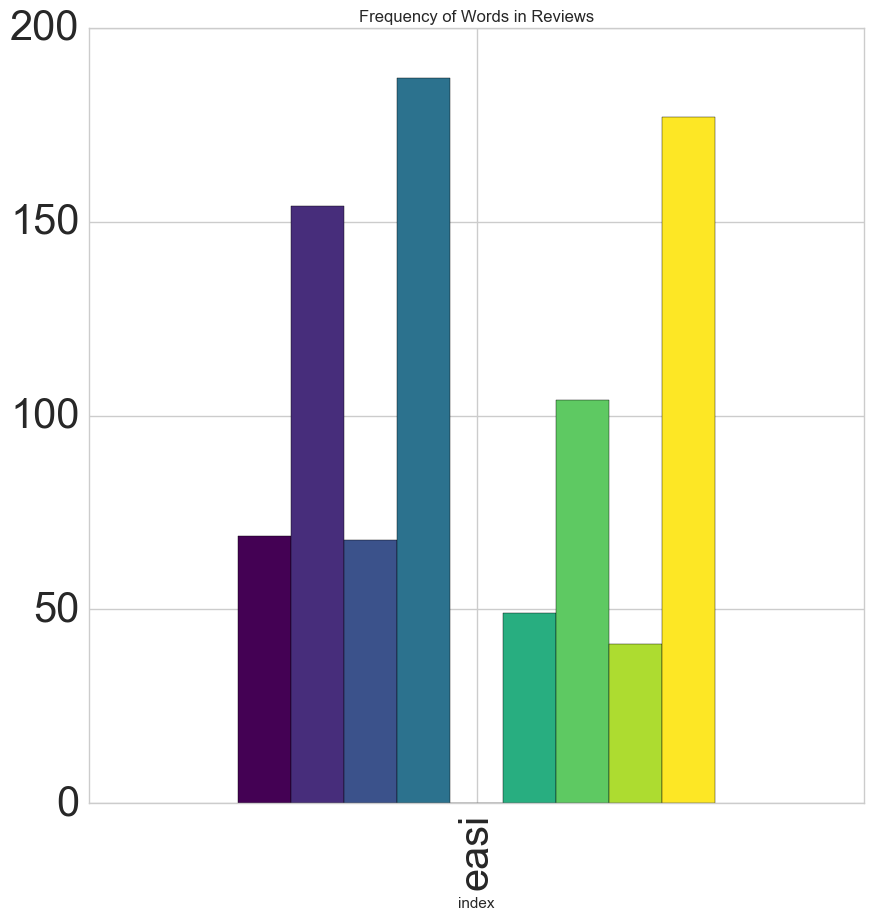

In [299]:
sns.set(style="whitegrid")

plt.rcParams["figure.figsize"] = [10,10]
plt.figure()

wordset_df[['index', 'BEF','GEF','BNF','GNF','spacer','BEM','GEM','BNM','GNM']].plot(
    kind='bar',
    x='index',
    width=.8,
    title="Frequency of Words in Reviews",
    cmap=plt.cm.viridis,
    fontsize=25,
    legend = False
)
plt.ylim([0,200])

plt.tick_params(labelsize=30)
#plt.title('Frequency of word \'care\'',fontsize=25)
#plt.legend(['BEF','GEF','BNF','GNF','','BEM','GEM','BNM','GNM'], loc=1, fontsize=25)
plt.show()


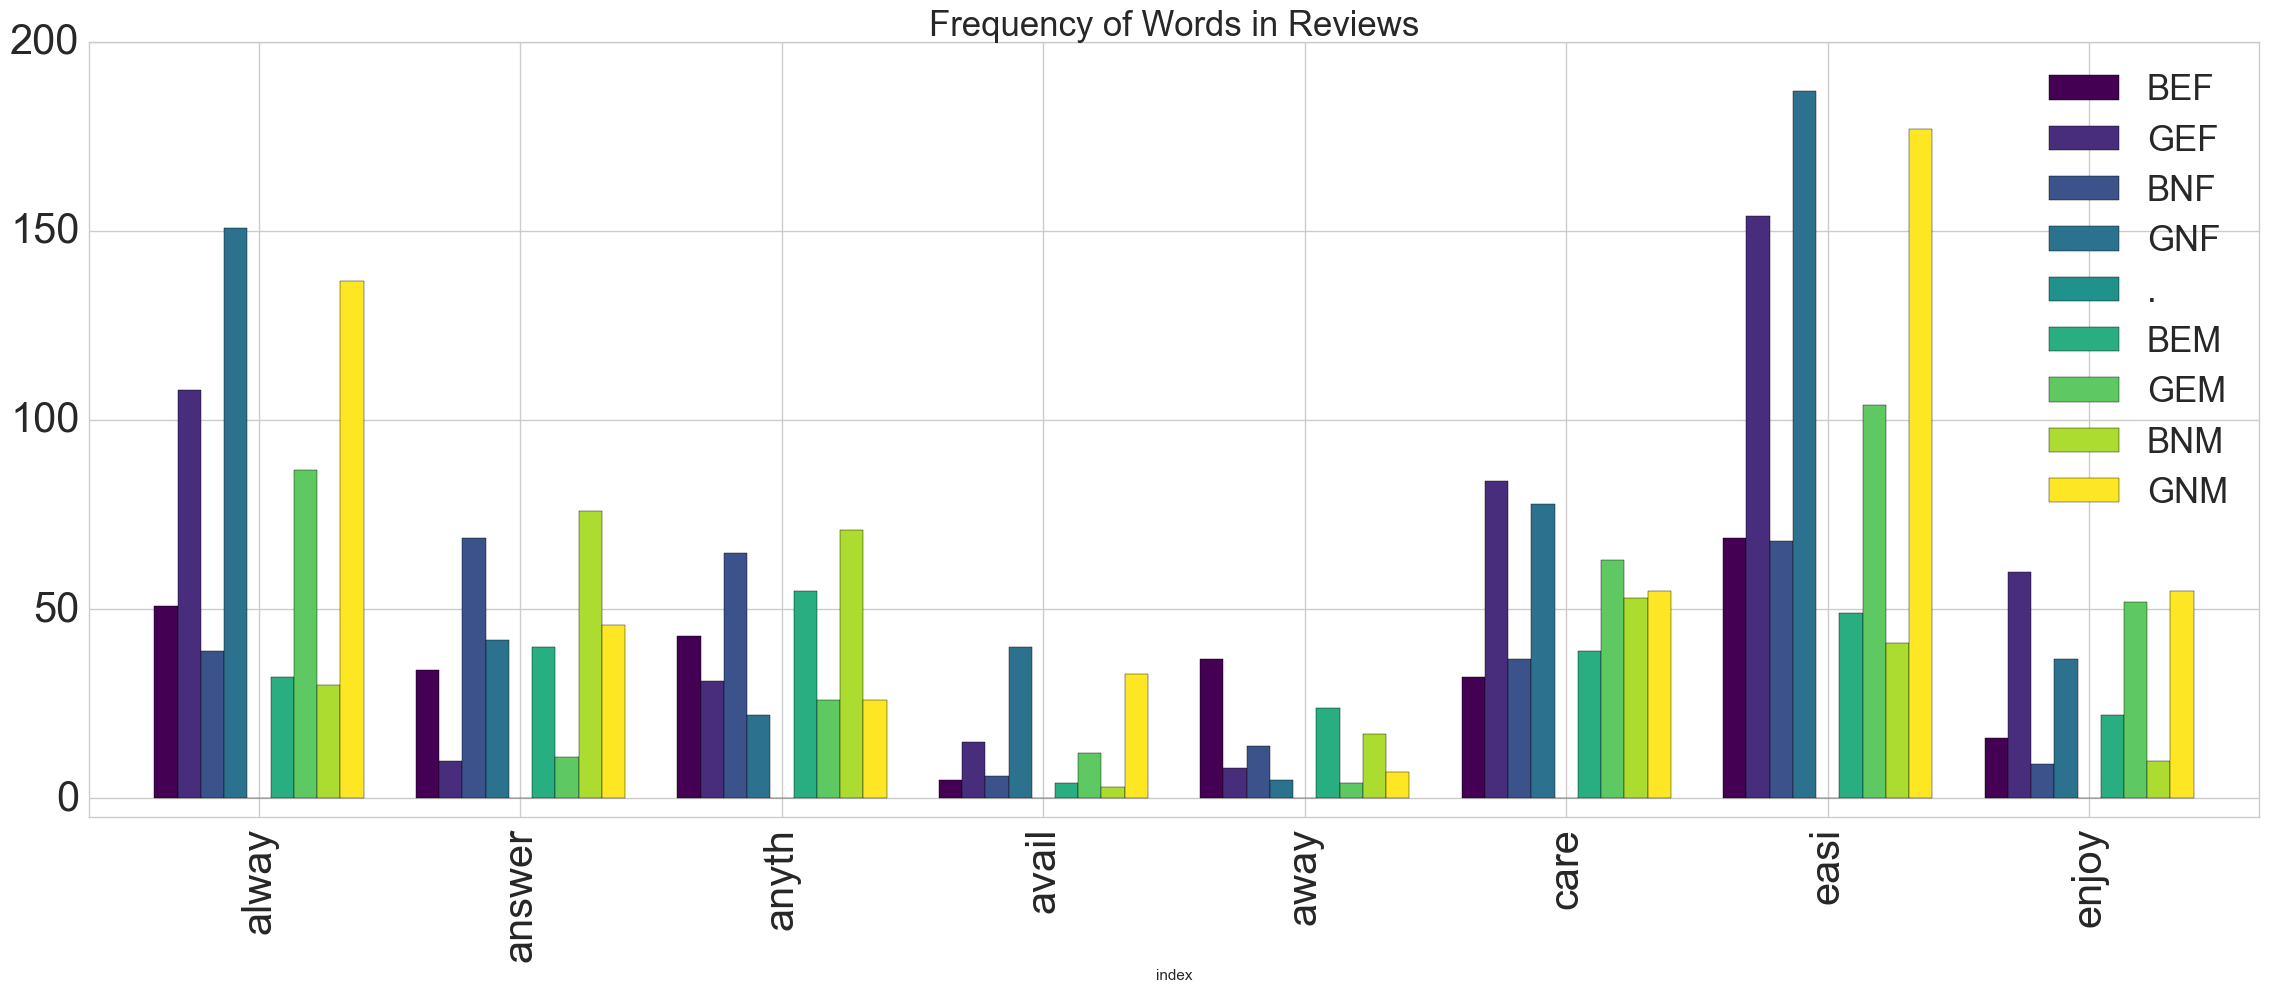

In [194]:
sns.set(style="whitegrid")

plt.rcParams["figure.figsize"] = [28,10]
plt.figure()

#g = sns.FacetGrid(interesting, col="index", col_wrap=4, size=2, ylim=(0, 1000))
#g.map(sns.barplot, 'index', 'BEF','GEF','BNF','GNF','BEM','GEM','BNM','GNM');
#ax = df[['V1','V2']].plot(kind='bar', title ="V comp", figsize=(15, 10), legend=True, fontsize=12)

int[['index', 'BEF','GEF','BNF','GNF','spacer','BEM','GEM','BNM','GNM']][0:8].plot(
    kind='bar',
    x='index',
    width=.8,
    title="Frequency of Words in Reviews",
    cmap=plt.cm.viridis,
    fontsize=25
)
plt.ylim([-5,200])

plt.tick_params(labelsize=30)
plt.title('Frequency of Words in Reviews',fontsize=25)
plt.legend(['BEF','GEF','BNF','GNF','.','BEM','GEM','BNM','GNM'], loc=1, fontsize=25)
plt.show()


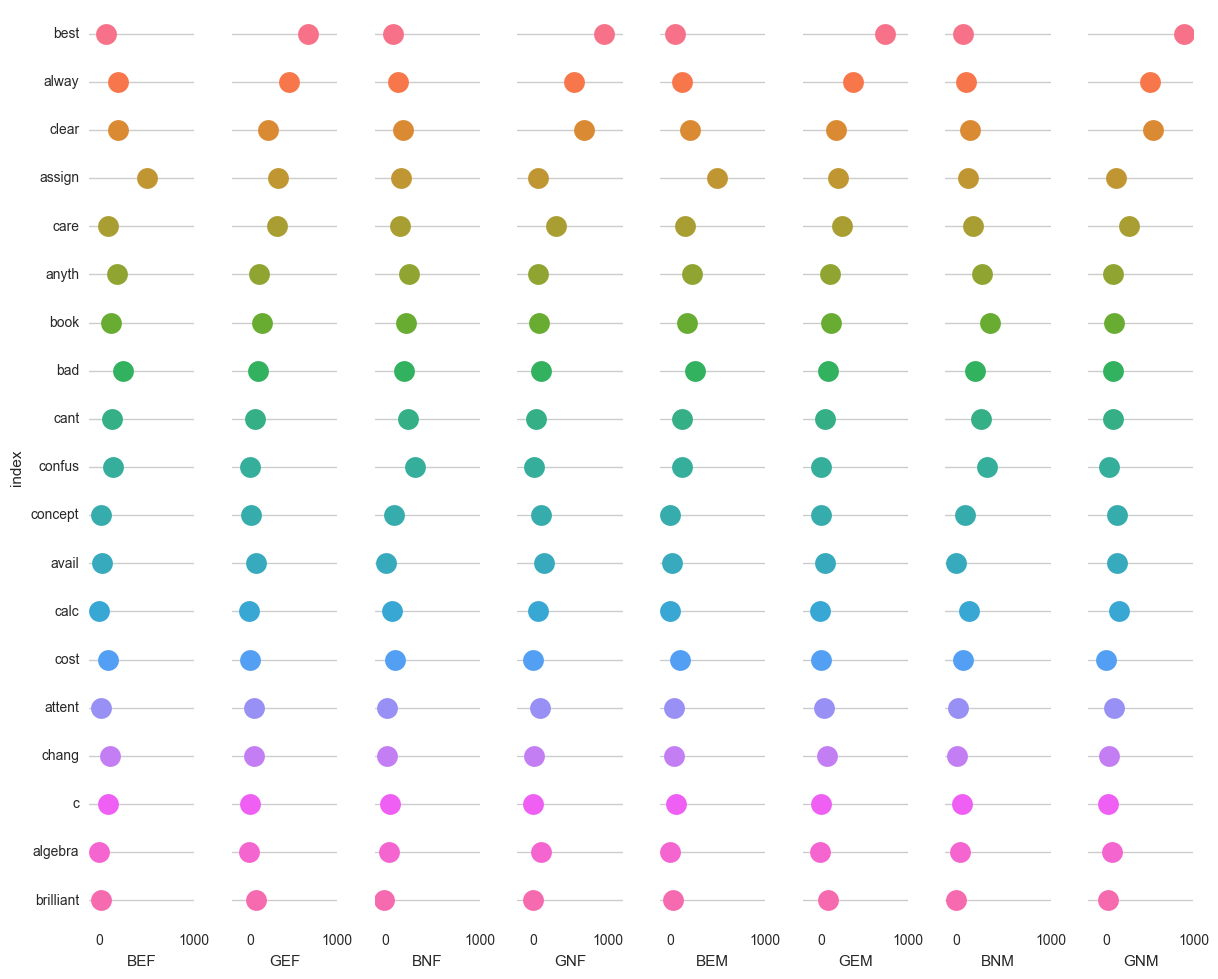

In [103]:
#first 20, but don't like this version! Moving on to bargraph
sns.set(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(interesting[0:19].sort_values('total', ascending=False),
                 x_vars=['BEF','GEF','BNF','GNF','BEM','GEM','BNM','GNM'], y_vars=["index"],
                 size=10, aspect=.15)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h",
      palette="husl", edgecolor="gray")

for ax in g.axes.flat:

    XXXXXXXX set axis for each of these to be the same! XXXXX or do a bar!!!!
    ax.set(xticks = [10,1000],xticklabels=[0,1000])
    
    # Make the grid 
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)


In [ ]:
int_words = ['answer',
 'ask',
 'aw',
 'awesome',
 "bad",
 'board',
 'calc',
 'care',
 'chanc',
 'chang',
 'clear',
 'concept',
 'drop',
 'easi',
 'enjoy',
 'extrem',
 'feel',
 'fun',
 'funni',
 'get',
 'got',
 'gpa',
 'grade',
 'great',
 'help',
 'hour',
 'imposs',
 'interest',
 'lectur',
 'like',
 'paper',
 'problem',
 'professor',
 'rude',
 'said',
 'say',
 'stupid',
 'succeed',
 'unclear',
 'understand',
 'year',
 'worst',
 'would']